In [ ]:
"""Para este projeto, estaremos explorando dados disponíveis publicamente de LendingClub.com. Lending Club conecta pessoas que precisam de dinheiro (mutuários)
com pessoas que têm dinheiro (investidores). Felizmente, como investidor,
você gostaria de investir em pessoas que mostraram um perfil de ter uma alta probabilidade de pagá-lo de volta. Vamos tentar criar um modelo que ajude a prever isso.

O clube de empréstimo teve um ano muito interessante em 2016, então vamos verificar alguns de seus dados e ter em mente o contexto. Esses dados são de antes mesmo de serem públicos.

Utilizaremos os dados de empréstimos de 2007-2010 e tentaremos classificar e prever se o mutuário pagou o empréstimo na íntegra.

Neste projeto, vou utilizar  Random Forests para tentar prever quando um usuário cadastrado não efetuará o pagamento de um empréstimo.

Aqui estão o que as colunas representam:

credit.policy: 1 se o cliente atender aos critérios de subscrição de crédito da LendingClub.com e 0 caso contrário.

purpose: O objetivo do empréstimo (possíveis valores "credit_card", "debt_consolidation", "educacional", "major_purchase", "small_business" e "all_other").

int.rate: a taxa de juros do empréstimo (uma taxa de 11% seria armazenada como 0.11). Os mutuários julgados por LendingClub.com para serem mais arriscados recebem taxas de juros mais elevadas.

installment: as parcelas mensais devidas pelo mutuário se o empréstimo for financiado.

log.annual.inc: O log natural da renda anual auto-relatada do mutuário.

dti: Ratio dívida / rendimento do tomador do empréstimo (montante da dívida dividido pela receita anual).

fico: a pontuação de crédito FICO do mutuário.

days.with.cr.line: O número de dias em que o mutuário teve uma linha de crédito.

revol.bal: Saldo rotativo do mutuário (montante não pago no final do ciclo de cobrança do cartão de crédito).

revol.util: taxa de utilização da linha rotativa do mutuário (o valor da linha de crédito usada em relação ao crédito total disponível).

inq.last.6mths: número de consultas do mutuário por credores nos últimos 6 meses.

delinq.2yrs: o número de vezes que o mutuário havia passado mais de 30 dias em um pagamento nos últimos 2 anos.

pub.rec: O número de registros públicos depreciativos do mutuário (arquivamentos de falências, ônus fiscais ou julgamentos)."""

In [11]:
# MVP Machine Learning & Analytics
# Aluno: Victor Martins de Araujo

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier




In [12]:
#carregando base de dados
# o arquivo loan_data.csv deve estar dentro da sample_data

# Download the raw CSV file

url = "https://raw.githubusercontent.com/VictorArauj0/Dataset/main/loan_data.csv"
response = requests.get(url)

# Save the content to a local file
with open("loan_data.csv", "w") as f:
    f.write(response.text)

# Read the CSV file into a pandas DataFrame
loans = pd.read_csv("loan_data.csv")

In [ ]:
"""Utilizei os recursos de plotagem incorporados ao seaborn e ao pandas.

 Vou criar um histograma de duas distribuições FICO umas sobre as outras, uma para cada um dos valores possíveis de credit.policy """

Text(0.5, 0, 'FICO')

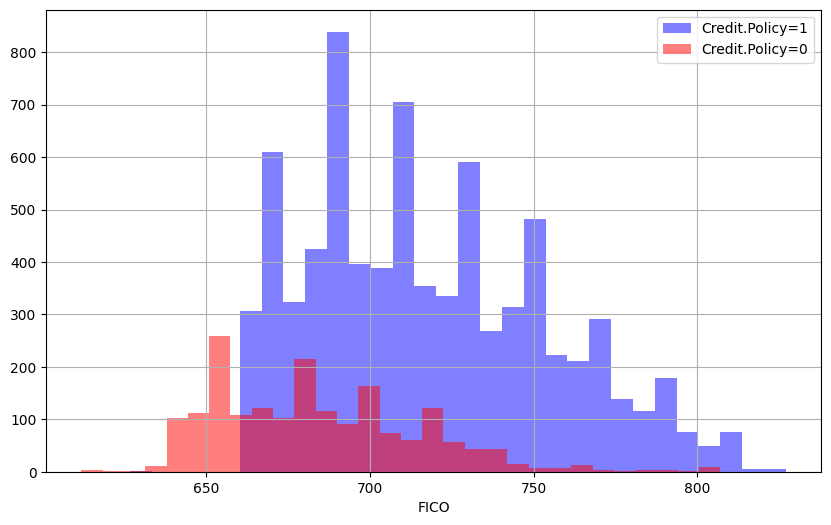

In [13]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')

loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

Text(0.5, 0, 'FICO')

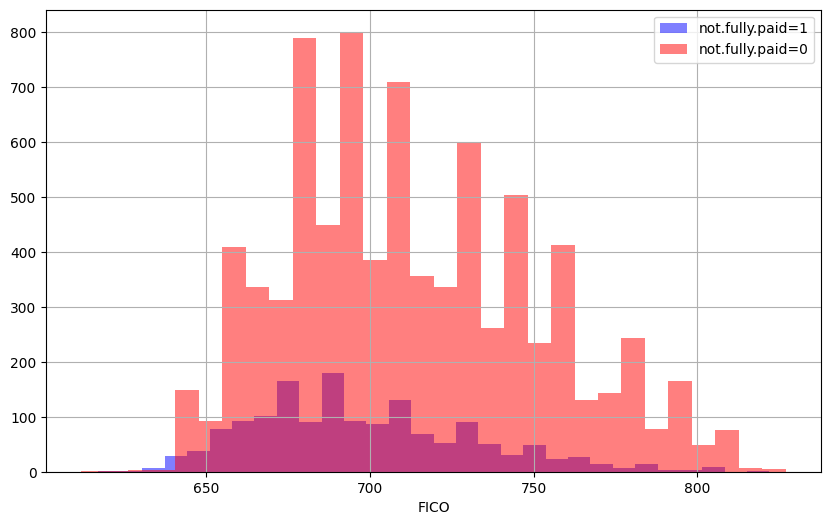

In [14]:
# Foi criado uma figura semelhante, mas dessa vez use a coluna not.fully.paid.

plt.figure(figsize=(10,6))
loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='not.fully.paid=1')
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='not.fully.paid=0')
plt.legend()
plt.xlabel('FICO')

<Axes: xlabel='purpose', ylabel='count'>

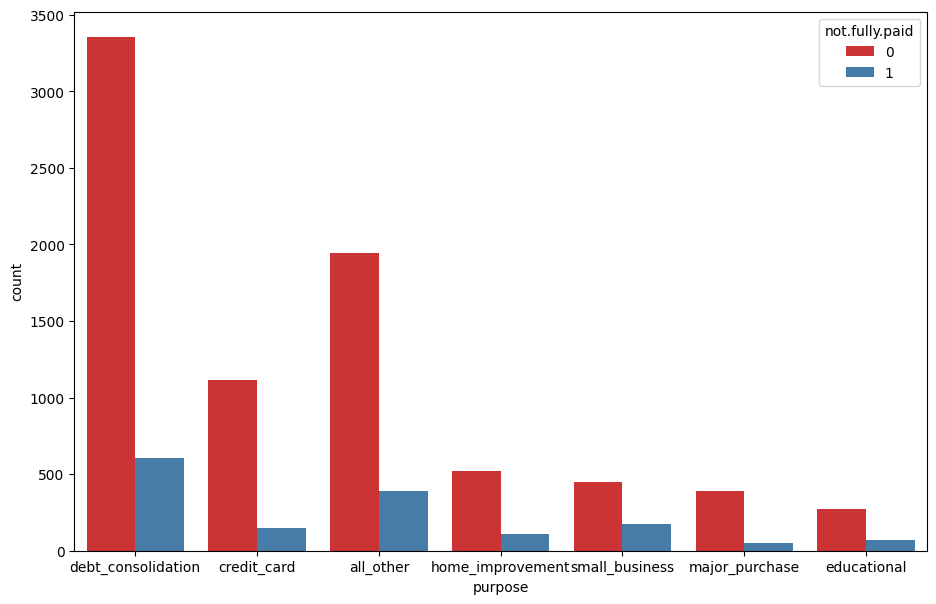

In [15]:
#Foi criado um countplot usando seaborn mostrando a contagens de empréstimos por finalidade, com a matiz de cor definido por not.fully.paid

plt.figure(figsize=(11,7))
sns.countplot(x='purpose',hue='not.fully.paid',data=loans,palette='Set1')

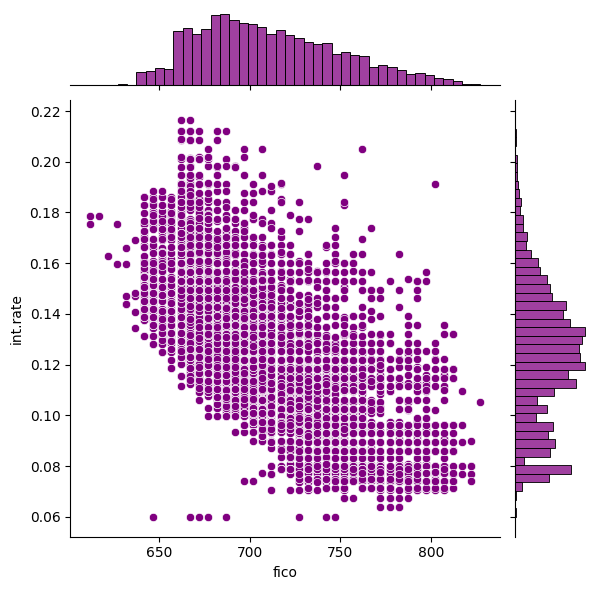

In [16]:
#Veja a tendência entre o índice FICO e a taxa de juros. Recrie o seguinte jointplot

sns.jointplot(x='fico',y='int.rate',data=loans,color='purple')

<Figure size 1100x700 with 0 Axes>

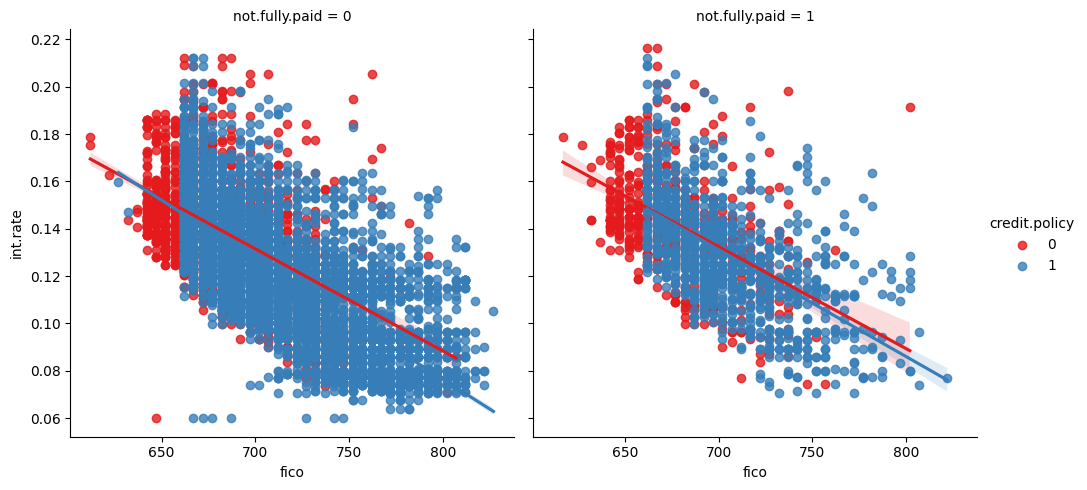

In [17]:
#foi criado os seguintes lmplots para ver se a tendência diferiu entre not.fully.paid e credit.policy.


plt.figure(figsize=(11,7))
sns.lmplot(y='int.rate',x='fico',data=loans,hue='credit.policy',
           col='not.fully.paid',palette='Set1')

In [32]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [18]:
# Preparando os dados para o nosso modelo de classificação de RandomForest!

#Gerei uma lista de com 1 elemento contendo a string 'purpose'.
cat_feats = ['purpose']

In [19]:
 #Utilizei "pd.get_dummies(loans, columns = cat_feats, drop_first = True)" para criar um DataFrame maior fixo que tenha novas colunas de recursos com variáveis dummy.
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True)

In [20]:
#exibindo resultado
final_data

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,False,False,False,False,False,False
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,False,False,False,False,False,False
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,False,True,False,False,False,False
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,False,False,False,True,False,False


In [21]:
# Usei sklearn para dividir em conjuntos de treino e conjuntos de teste.
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [22]:
#treinei uma única árvore de decisão primeiro!

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [23]:
predictions = dtree.predict(X_test)

In [24]:
# o modelo não teve uma precisão ideal
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2431
           1       0.19      0.23      0.21       443

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.75      0.73      0.74      2874



In [26]:
#o modelo não teve um bom desempenho
print(confusion_matrix(y_test,predictions))

[[2000  431]
 [ 343  100]]


In [27]:
# modelo de RandomForest

rfc = RandomForestClassifier(n_estimators=200)

In [28]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [29]:
predictions = rfc.predict(X_test)

In [30]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.54      0.03      0.06       443

    accuracy                           0.85      2874
   macro avg       0.70      0.51      0.49      2874
weighted avg       0.80      0.85      0.78      2874



In [31]:
# na pratica os dois modelos não teve um bom resultado
print(confusion_matrix(y_test,predictions))

[[2420   11]
 [ 430   13]]


In [ ]:
""" Nenhum dos dois performou muito bem.
Seria necessário mais engenharia nos dados para que talvez conseguissemos algum resultado superior."""